# Title
Madeline M. Warndorf 
Graduate Student, EMSE Dept.
George Washington University
Washington, D.C.
mwarndorf65@gwu.edu

## I. General Analysis of Dataset and Preprocessing
### A. Importing Cleaned Final Dataset

In [186]:
import pandas as pd
from sklearn.utils import shuffle

#Importing Data as Pandas Dataframe
fars_file = "MLEMSE6992/fulldataset1516.csv"
fars_df = pd.read_csv(fars_file)

#print(fars_df.head())
fars_df = shuffle(fars_df)


#Casenum and vehnum were dropped because those were assigned by the police after the accident.
d_col = ['statenum','day','month','year','landuse','age','bodytype','vfatcount','numoccs','modelyr']
t_col = ['cellphone_use']

### B.Determining if Dataset Needs to Be Undersampled

In [187]:
#Determine if there is a need to undersample
celluse = fars_df[fars_df["cellphone_use"] == 1]
no_celluse = fars_df[fars_df["cellphone_use"] == 0]
print("The number of accidents involving cellphones: {}".format(len(celluse)))
print("The number of accidents that did not involve cellphones: {}".format(len(no_celluse)))

total_accidents = len(celluse) + len(no_celluse)
print("The total number of accidents: %d" % total_accidents)
#Percentage of accidents involving cellphones
percentage = (len(celluse)/ total_accidents) * 100
print("The percentage of accidents that involved cellphones: {:.4}%".format(percentage))


The number of accidents involving cellphones: 830
The number of accidents that did not involve cellphones: 77587
The total number of accidents: 78417
The percentage of accidents that involved cellphones: 1.058%


### C. Creating New Dataframe with Undersampled Data
Storing new dataframe as a CSV to allow for this section of code not to be re-run and so the data isn't resampled to produce different answers down the line.

In [188]:
#Need to undersample
m = len(celluse)
selected_no_celluse = no_celluse.sample(m)


#Storing and Shuffling new dataset
undersampled_df = pd.concat([selected_no_celluse, celluse], ignore_index=True)
undersampled_df = shuffle(undersampled_df)

undersampled_df.to_csv("FARS_undersampled_df.csv", sep=",",index=False)


### D. Visualization of Relationships between Cellphone Usage and Each Feature

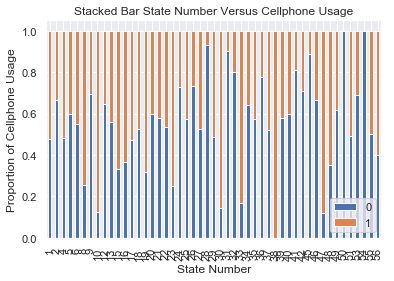

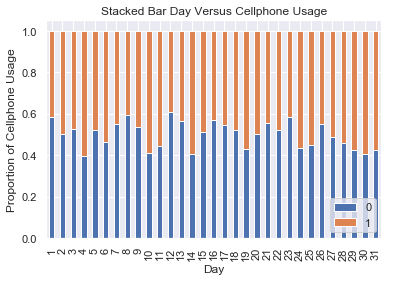

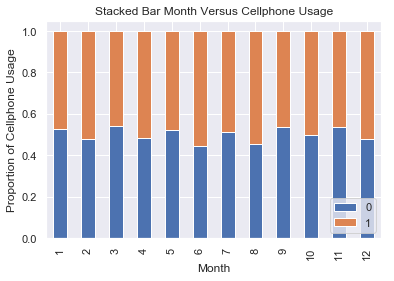

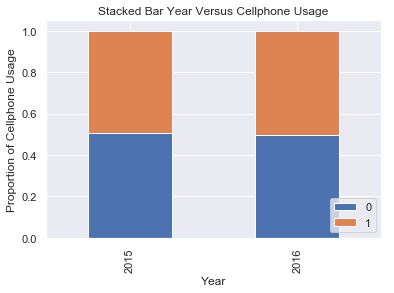

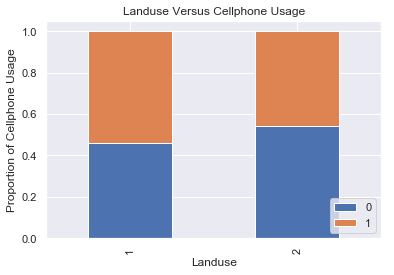

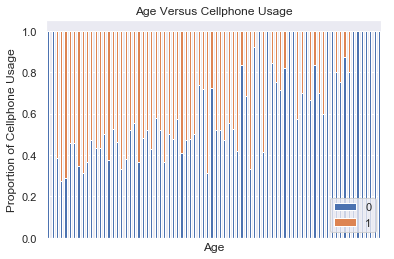

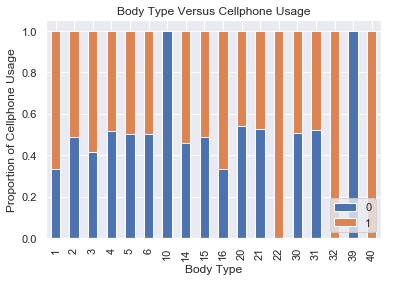

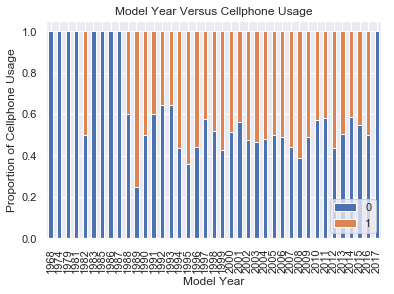

In [225]:
from math import e
import scipy
from scipy import stats

plt.rc("font", size=14)
import seaborn as sns
sns.set(style="dark")
sns.set(style="darkgrid", color_codes=True)

dataframe_all = pd.read_csv("FARS_undersampled_df.csv")

y = dataframe_all["cellphone_use"]


table=pd.crosstab(dataframe_all["statenum"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar State Number Versus Cellphone Usage')
plt.xlabel('State Number')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('State_Versus_Cellphone')

table=pd.crosstab(dataframe_all["day"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Day Versus Cellphone Usage')
plt.xlabel('Day')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Day_Versus_Cellphone')

table=pd.crosstab(dataframe_all["month"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Month Versus Cellphone Usage')
plt.xlabel('Month')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Month_Versus_Cellphone')

table=pd.crosstab(dataframe_all["year"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Stacked Bar Year Versus Cellphone Usage')
plt.xlabel('Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Year_Versus_Cellphone')

table=pd.crosstab(dataframe_all["landuse"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Landuse Versus Cellphone Usage')
plt.xlabel('Landuse')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Landuse Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["age"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Age Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Age')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Age Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["bodytype"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Body Type Versus Cellphone Usage')
plt.xlabel('Body Type')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Body Type Versus Cellphone Usage')

table=pd.crosstab(dataframe_all["modelyr"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('Model Year Versus Cellphone Usage')
plt.xlabel('Model Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Model Year Versus Cellphone Usage')

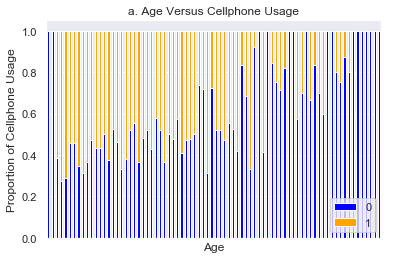

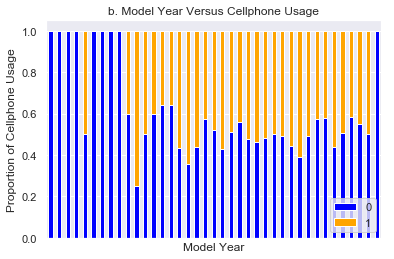

In [231]:

table=pd.crosstab(dataframe_all["age"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['blue','orange'])
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('a. Age Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Age')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Age Versus Cellphone Usage')


table=pd.crosstab(dataframe_all["modelyr"],y)
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True, color=['blue','orange'])
plt.legend(bbox_to_anchor=(1,0), loc="lower right")
plt.title('b. Model Year Versus Cellphone Usage')
plt.xticks([])
plt.xlabel('Model Year')
plt.ylabel('Proportion of Cellphone Usage')
plt.savefig('Model Year Versus Cellphone Usage')

In [235]:
print("Age ranged from: %d to %d." % (dataframe_all["age"].min(),dataframe_all["age"].max()))
print("Model ranged from: %d to %d." % (dataframe_all["modelyr"].min(),dataframe_all["modelyr"].max()))

Age ranged from: 14 to 93.
Model ranged from: 1968 to 2017.


### E. Preprocessing the Data

In [308]:
from sklearn.feature_extraction import DictVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
d_col = ['statenum','day','month','year','landuse','age','bodytype','vfatcount','numoccs','modelyr']
#Create data and target
undersampled_df = pd.read_csv("FARS_undersampled_df.csv", sep = ",")
undersampled_df = shuffle(undersampled_df)

far_data = undersampled_df[d_col]

far_dict_data = far_data.T.to_dict('dict').values()
vectorizer = DictVectorizer(sparse=False)
fardata = vectorizer.fit_transform(far_dict_data)


fars_target_raw = undersampled_df['cellphone_use']
df_t = pd.get_dummies(fars_target_raw)
far_target = df_t[0]

fartarget = far_target.values

print(fardata)
print(fartarget)

[[3.300e+01 4.000e+00 1.200e+01 ... 5.300e+01 0.000e+00 2.016e+03]
 [4.500e+01 4.000e+00 2.400e+01 ... 2.100e+01 1.000e+00 2.016e+03]
 [1.800e+01 4.000e+00 1.700e+01 ... 4.200e+01 1.000e+00 2.015e+03]
 ...
 [2.700e+01 3.100e+01 8.000e+00 ... 1.700e+01 0.000e+00 2.015e+03]
 [2.200e+01 6.000e+00 2.500e+01 ... 4.800e+01 1.000e+00 2.015e+03]
 [2.100e+01 2.000e+00 2.500e+01 ... 4.800e+01 1.000e+00 2.016e+03]]
[1 0 1 ... 1 0 0]


## II. Deciding on Model
### A. Finding Best Parameters Using GridSearchCV and the Metric Accuracy
Finding best parameters for each type of model based on accuracy. 

In [310]:
#Using GridSearch to determine the best Logistic Regression Model
#Setting parameters
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
np.random.seed(300)
from warnings import filterwarnings
filterwarnings('ignore')

#Logistic Regression
param_grid = [{'C': [1e-1, 1e0, 1e2], 'solver': ['lbfgs'],'max_iter': [100,1000,5000,10000]},
              {'C': [1e-1, 1e0, 1e2], 'solver': ['liblinear'],'max_iter': [100,1000,5000]}]
lr = LogisticRegression()

me_grid = GridSearchCV(lr, param_grid, cv=10, scoring = 'f1')
me_grid.fit(fardata, fartarget)

print("__MaxEnt (Logistic Regression)__")
print("Best F1 Score: %0.3f" % me_grid.best_score_)
print("Best Parameters set:")
print(me_grid.best_estimator_.get_params())

#Naive Bayes: GaussianNB
param_gridNB = [{'var_smoothing': [1e-15,1e-9,0,1e9]}]
gnb = GaussianNB()

gnb_grid = GridSearchCV(gnb, param_gridNB, cv=10, scoring = 'f1')
gnb_grid.fit(fardata, fartarget)

print("\n")
print("__Naive Bayes (Gaussian)__")
print("Best F1 Score: %0.3f" % gnb_grid.best_score_)
print("Best Parameters set:")
print(gnb_grid.best_estimator_.get_params())

#SVC RBF
svc = svm.SVC()

param_gridSVC = [{'C': [1e0, 1e2, 1e5], 'kernel': ['rbf'], 'gamma': [0.1, 10]}]

svc_grid = GridSearchCV(svc, param_gridSVC, cv=10, scoring = 'f1')

svc_grid.fit(fardata, fartarget)

print("\n")
print("__Support Vector RBF Classifier__")
print("Best F1 Score: %0.3f" % svc_grid.best_score_)
print("Best Parameters set:")
print(svc_grid.best_estimator_.get_params())

#LinearSVC
svcL = svm.LinearSVC()

param_gridSVCL = [{'C': [1e0, 1e2, 1e3], 'loss':['hinge','squared_hinge'], 'max_iter': [1000, 5000, 10000]}]

svc_gridL = GridSearchCV(svcL, param_gridSVCL, cv=10, scoring = 'f1')

svc_gridL.fit(fardata, fartarget)

print("\n")
print("__Support Vector Linear Classifier__")
print("Best F1 Score: %0.3f" % svc_gridL.best_score_)
print("Best Parameters set:")
print(svc_gridL.best_estimator_.get_params())

__MaxEnt (Logistic Regression)__
Best F1 Score: 0.591
Best Parameters set:
{'C': 100.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'max_iter': 100, 'multi_class': 'warn', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}


__Naive Bayes (Gaussian)__
Best F1 Score: 0.542
Best Parameters set:
{'priors': None, 'var_smoothing': 1e-15}


__Support Vector RBF Classifier__
Best F1 Score: 0.641
Best Parameters set:
{'C': 1.0, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 0.1, 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


__Support Vector Linear Classifier__
Best F1 Score: 0.470
Best Parameters set:
{'C': 1000.0, 'class_weight': None, 'dual': True, 'fit_intercept': True, 'intercept_scaling': 1, 'loss': 'squared_hinge', 'max_iter': 

### B.Classification Reports for Each Model

In [312]:
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn import metrics

print("__MaxEnt (Logistic Regression)__")
log_reg = LogisticRegression(C = 100, solver = 'liblinear', max_iter = 100)
print("Model: %s" % log_reg)
lr_scores = cross_val_score(log_reg, fardata, fartarget, cv=10)
print("Average accuracy score for Logistic Regression classifier: %.3f" % np.mean(lr_scores))
log_reg.fit(fardata[333:],fartarget[333:])

lry_predict = log_reg.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], lry_predict))


print("__Naive Bayes (Gaussian)__")
gnb = GaussianNB(var_smoothing = 1e-15)
print("Model: %s" % gnb)
gnb_scores = cross_val_score(gnb, fardata, fartarget, cv=10)
print("Average accuracy score for Gaussian Naive Bayes classifier: %.3f" % np.mean(gnb_scores))
gnb.fit(fardata[333:],fartarget[333:])

gnb_predict = gnb.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], gnb_predict))


print("__Support Vector RBF Classifier__")
svc = svm.SVC(C = 1, kernel = 'rbf', gamma = 0.1, max_iter = -1)
print("Model: %s" % svc)
svc_scores = cross_val_score(svc, fardata, fartarget, cv=10)
print("Average accuracy score for SVC classifier: %.3f" % np.mean(svc_scores))

svc.fit(fardata[333:], fartarget[333:])
svcy_predict = svc.predict(fardata[:333])
print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], svcy_predict))

print("__LinearSVC__")
linear_svc_classifier = svm.LinearSVC(C = 1000, max_iter = 5000, loss = 'squared_hinge')
print("Model: %s" % linear_svc_classifier)
linearsvc_scores = cross_val_score(linear_svc_classifier, fardata, fartarget, cv=10)
print("Average accuracy score for LinearSVC classifier: %.3f" % np.mean(linearsvc_scores))

linear_svc_classifier.fit(fardata[333:],fartarget[333:])
y_predict = linear_svc_classifier.predict(fardata[:333])

print("___Classification Report___")
print(metrics.classification_report(fartarget[:333], y_predict))


__MaxEnt (Logistic Regression)__
Model: LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)
Average accuracy score for Logistic Regression classifier: 0.612
___Classification Report___
              precision    recall  f1-score   support

           0       0.60      0.63      0.61       182
           1       0.52      0.49      0.51       151

   micro avg       0.56      0.56      0.56       333
   macro avg       0.56      0.56      0.56       333
weighted avg       0.56      0.56      0.56       333

__Naive Bayes (Gaussian)__
Model: GaussianNB(priors=None, var_smoothing=1e-15)
Average accuracy score for Gaussian Naive Bayes classifier: 0.607
___Classification Report___
              precision    recall  f1-score   support

           0       0.60      0.71      0.65

### Finding the ROC and AUC for Each Best Parameter Model

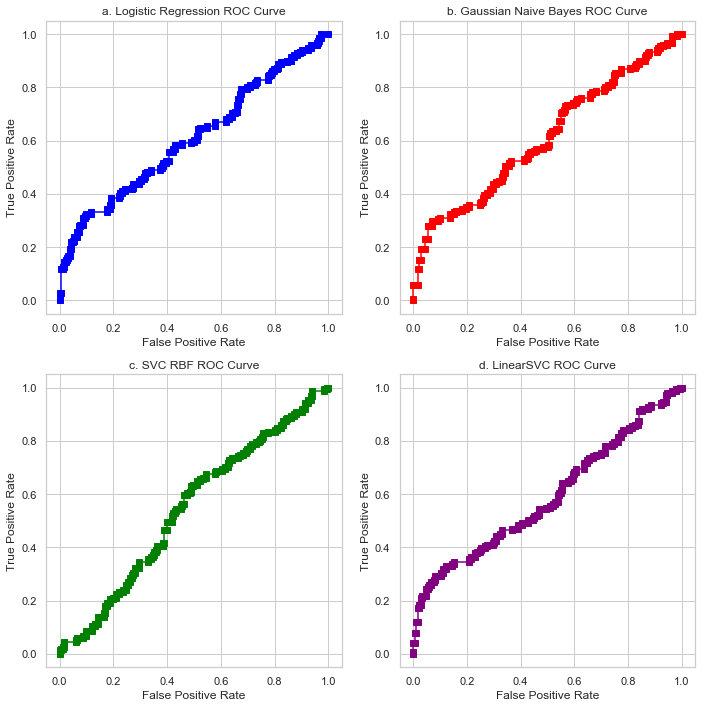

AUC for Logisitic Regression (MaxEnt): 0.609
AUC for Gaussian Naive Bayes: 0.612
AUC for SVC RBF: 0.545
AUC for LinearSVC: 0.590


In [313]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
#Setting test size to 20% of the data meaning it will be the last 333 entries.

#Logistic Regression
lr_y_score = log_reg.predict_proba(fardata[:333])[:,1]

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],lr_y_score)
lr_roc_auc = metrics.auc(f_positive, t_positive)


fig, axes = plt.subplots(2, 2, figsize = (10,10))
fig.subplots_adjust(top=0.99, left=.01, right=0.99,
                    hspace=0.3, wspace=0.3)
fig.figsize = (10,10)
((ax1, ax2), (ax3, ax4)) = axes
ax1.set_title('a. Logistic Regression ROC Curve')
ax1.plot(f_positive, t_positive, c='blue', marker="s", label="Logistic Regression (MaxEnt)")
ax1.set_ylabel('True Positive Rate')
ax1.set_xlabel('False Positive Rate')



#Gaussian Naive Bayes
gnb_y_score = gnb.predict_log_proba(fardata[:333])[:,1]

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],gnb_y_score)
gnb_roc_auc = metrics.auc(f_positive, t_positive)

ax2.set_title('b. Gaussian Naive Bayes ROC Curve')
ax2.plot(f_positive, t_positive, c='red', marker="s", label="Gaussian Naive Bayes")
ax2.set_ylabel('True Positive Rate')
ax2.set_xlabel('False Positive Rate')


#SVC RBF
svc_y_score = svc.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],svc_y_score)
svc_roc_auc = metrics.auc(f_positive, t_positive)


ax3.set_title('c. SVC RBF ROC Curve')
ax3.plot(f_positive, t_positive, c='green', marker="s", label="SVC RBF")
ax3.set_ylabel('True Positive Rate')
ax3.set_xlabel('False Positive Rate')



#LinearSVC
y_score = linear_svc_classifier.decision_function(fardata[:333])

f_positive, t_positive, thresholds = metrics.roc_curve(fartarget[:333],y_score)
roc_auc = metrics.auc(f_positive, t_positive)


ax4.set_title('d. LinearSVC ROC Curve')
ax4.plot(f_positive, t_positive, c='purple', marker="s", label="LinearSVC")
ax4.set_ylabel('True Positive Rate')
ax4.set_xlabel('False Positive Rate')
plt.tight_layout()
plt.show()



print("AUC for Logisitic Regression (MaxEnt): %.3f" % lr_roc_auc)
print("AUC for Gaussian Naive Bayes: %.3f" % gnb_roc_auc)
print("AUC for SVC RBF: %.3f" % svc_roc_auc)
print("AUC for LinearSVC: %.3f" % roc_auc)

## Results
**Gaussian Naive Bayes**

In [314]:
print(gnb.class_prior_)
print(vectorizer.get_feature_names())
print(gnb.sigma_[0])

[0.48831952 0.51168048]
['age', 'bodytype', 'day', 'landuse', 'modelyr', 'month', 'numoccs', 'statenum', 'vfatcount', 'year']
[2.05005058e+02 1.15772288e+02 7.90467440e+01 2.45389422e-01
 3.58785794e+01 1.14934842e+01 9.01403654e-01 2.91908929e+02
 3.23023834e-01 2.49978567e-01]


In [307]:
X = [i for i in range()]
X0 = gnb.sigma_[0]
X1 = gnb.sigma_[1]
plt.line(X0)

AttributeError: module 'matplotlib.pyplot' has no attribute 'line'

In [143]:
import pickle
#Dumping Result into a pickle file
pickleoutput = open('LinearSVC_Coefs.pkl', 'wb')
pickle.dump(linear_svc_coefs, pickleoutput)
pickleoutput.close()

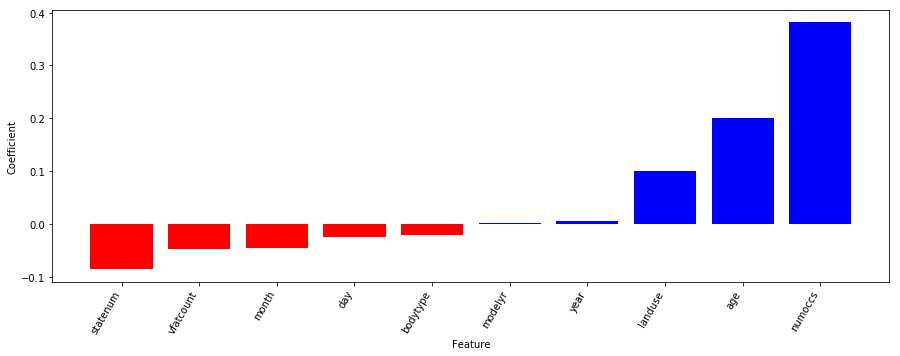

In [142]:
#Idea from:
'''A. Bakharia, “Visualising Top Features in Linear SVM with Scikit Learn and Matplotlib,” 
        Medium, 31-Jan-2016. [Online]. 
        Available: https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d. 
        [Accessed: 29-Apr-2019].'''
coefs = linear_svc_classifier.coef_.ravel()
positive_coefs = np.argsort(coefs)[-5:]
negative_coefs = np.argsort(coefs)[:5]
coefficients = np.hstack([negative_coefs, positive_coefs])
feature_names = vectorizer.get_feature_names()

 # create plot
plt.figure(figsize=(15, 5))
colors = ['red' if c < 0 else 'blue' for c in coefs[coefficients]]
plt.bar(np.arange(2 * 5), coefs[coefficients], color=colors)
feature_names = np.array(feature_names)
plt.xticks(np.arange(0, 2 * 5), feature_names[coefficients], rotation=60, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient")
plt.show()

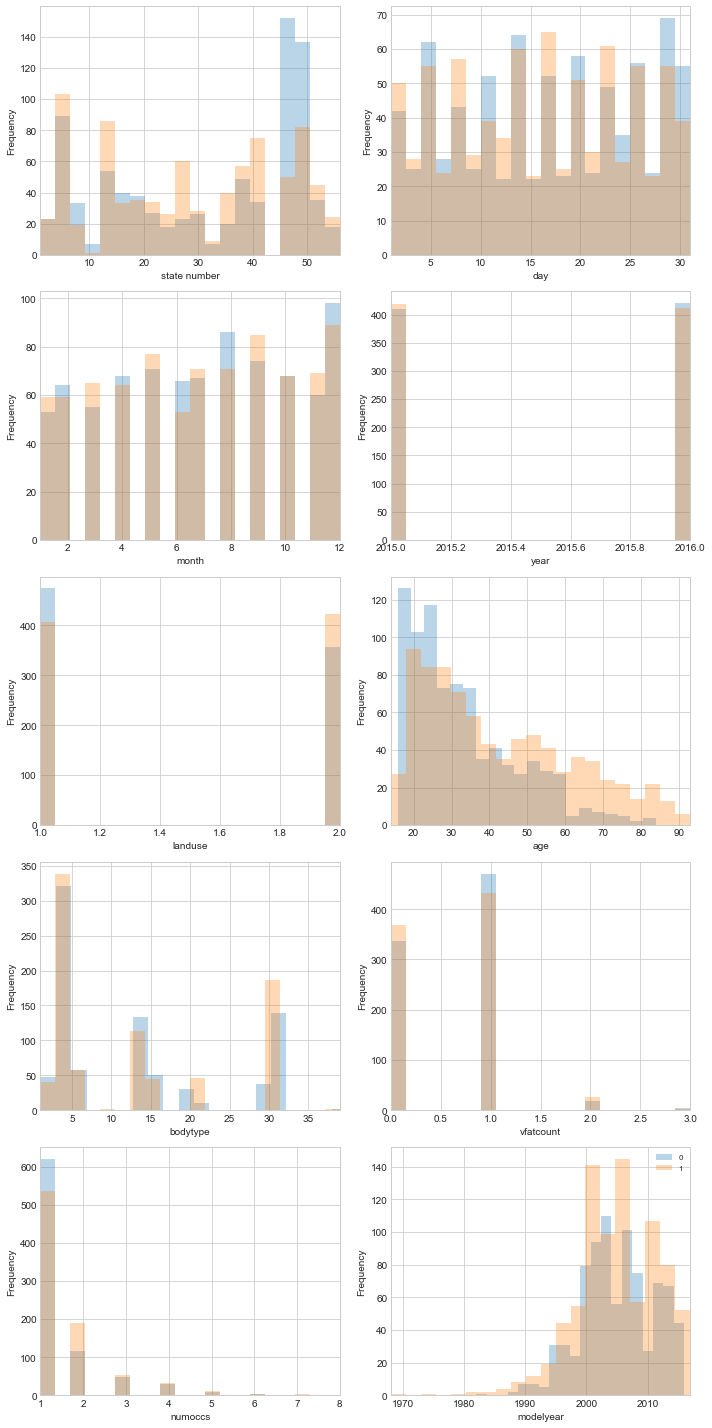

In [193]:
X = far_data.values
y = far_target.values


from matplotlib import pyplot as plt
import numpy as np
import math

label_dict = {0: 'No-Cellphone',
              1: 'Cellphone'}

feature_dict = {0: 'state number',
                1: 'day',
                2: 'month',
                3: 'year',
                4: 'landuse', 
                5: 'age', 
                6: 'bodytype', 
                7: 'vfatcount', 
                8: 'numoccs', 
                9: 'modelyear'}

with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(10, 20))
    for cnt in range(10):
        plt.subplot(5, 2, cnt+1)
        for lab in (0, 1):
            plt.hist(X[y==lab, cnt],
                     label=lab,
                     bins=20,
                     alpha=0.3,)
            plt.xlim(X[y==lab, cnt].min(), X[y==lab, cnt].max())
        plt.xlabel(feature_dict[cnt])
        plt.ylabel("Frequency")
    plt.legend(loc='upper right', fancybox=True, fontsize=8)

    plt.tight_layout()
    plt.show()